# DATA PROJECT - JPS

In this project we analyse the development of the house and aparment prices in Denmark. We compare the prices and growth rate of houses and apartments in Copenhagen as well as the difference of the change in prices between counties in Denmark. 

Importing the needed packages:

In [2]:
%pip install pandas-datareader
%pip install git+https://github.com/elben10/pydst
%pip install matplotlib-venn

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
from scipy.stats.mstats import gmean

import pandas_datareader 
import pydst 

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# user written modules
import dataproject

Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/elben10/pydst to /private/var/folders/5k/v848_lfn4c7fkwyhsjyv_0b40000gn/T/pip-req-build-dr6uu7uv
  Running command git clone --filter=blob:none --quiet https://github.com/elben10/pydst /private/var/folders/5k/v848_lfn4c7fkwyhsjyv_0b40000gn/T/pip-req-build-dr6uu7uv
  Resolved https://github.com/elben10/pydst to commit bb347560a1b3c17684fda072c829658da38f5a72
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Read and clean data

Importing and cleaning the data for apartments

In [3]:
# Loading the Data from statistikbanken
filename1 = 'Ejerlejligheder.xlsx'
pd.read_excel(filename1).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),"Ejerlejligheder, i alt",Hele landet,421.0,419.0,452.0,474.0,514.0,536.0,...,1845.0,1945.0,2063.0,2156.0,2369.0,2470.0,2570.0,2800.0,3005.0,2847.0
3,NaN,NaN,NaN,Region Hovedstaden,446.0,443.0,482.0,502.0,538.0,557.0,...,2166.0,2236.0,2351.0,2511.0,2813.0,2958.0,3066.0,3351.0,3664.0,3520.0
4,NaN,NaN,NaN,Landsdel Byen København,421.0,417.0,453.0,475.0,510.0,529.0,...,2341.0,2411.0,2570.0,2798.0,3182.0,3355.0,3449.0,3730.0,4174.0,4026.0


In [4]:
# Now we are dropping rows
ap = pd.read_excel(filename1, skiprows=2)

# Now we drop the first three columns
del ap['Unnamed: 0'], ap['Unnamed: 1'], ap['Unnamed: 2']

# Now we rename the variable 'Unnamed: 3' 
ap.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'ap{i}' 
ap.rename(columns = col_dict, inplace=True)

# We are only interesetd in the Countys so we drop the regions and the whole country
I = ap.County.str.contains('Region')
I |= ap.County.str.contains('Hele landet')
ap.loc[I, :]
ap = ap.loc[I == False]

# We reset the index 
ap.reset_index(inplace = True, drop = True) # Drop old index too
ap.iloc[0:5,:]

# We convert the index from wide to long
ap_long = pd.wide_to_long(ap, stubnames='ap', i='County', j='year')
ap_long.head(11)

,,ap
County,year,
Landsdel Byen København,1992,421
Landsdel Københavns omegn,1992,474
Landsdel Nordsjælland,1992,504
Landsdel Bornholm,1992,377
Landsdel Østsjælland,1992,466
Landsdel Vest- og Sydsjælland,1992,338
Landsdel Fyn,1992,338
Landsdel Sydjylland,1992,374
Landsdel Østjylland,1992,434


Importing and cleaning the data for Houses

In [5]:
# Loading the Data from statistikbanken
filename2 = 'Familiehuse.xlsx'
pd.read_excel(filename2).head(5)

,"Ejendomssalg efter overdragelsesformer, nøgletal, ejendomskategori, område og tid",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,Enhed: -,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,...,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0
2,Almindelig fri handel,Gennemsnitlig pris pr. ejendom (1000 kr),Enfamiliehuse,Hele landet,551.0,565.0,622.0,656.0,753.0,806.0,...,1883.0,1955.0,2082.0,2122.0,2209.0,2257.0,2335.0,2477.0,2639.0,2464.0
3,NaN,NaN,NaN,Region Hovedstaden,777.0,789.0,876.0,935.0,1088.0,1195.0,...,2965.0,3075.0,3310.0,3465.0,3623.0,3754.0,3873.0,4231.0,4723.0,4471.0
4,NaN,NaN,NaN,Landsdel Byen København,767.0,785.0,856.0,917.0,1063.0,1169.0,...,3535.0,3775.0,4129.0,4441.0,4725.0,4938.0,5128.0,5708.0,6198.0,6146.0


In [9]:
# Now we are dropping rows
house = pd.read_excel(filename2, skiprows=2)

# Now we drop the first three columns
del house['Unnamed: 0'], house['Unnamed: 1'], house['Unnamed: 2']

# Now we rename the variable 'Unnamed: 3' 
house.rename(columns = {'Unnamed: 3':'County'},inplace=True)
col_dict = {}
for i in range(1992, 2022+1): # range goes from 2008 to but not including 2018
    col_dict[str(i)] = f'house{i}' 
house.rename(columns = col_dict, inplace=True)

# We are only interesetd in the Countys so we drop the regions and the whole country
J = house.County.str.contains('Region')
J |= house.County.str.contains('Hele landet')
house.loc[I, :]
house = house.loc[I == False]

# We reset the index 
house.reset_index(inplace = True, drop = True) # Drop old index too
house.iloc[0:5,:]

# We convert the index from wide to long
house_long = pd.wide_to_long(house, stubnames='house', i='County', j='year')
house_long.head(11)

,,house
County,year,
Landsdel Byen København,1992,767
Landsdel Københavns omegn,1992,836
Landsdel Nordsjælland,1992,797
Landsdel Bornholm,1992,335
Landsdel Østsjælland,1992,704
Landsdel Vest- og Sydsjælland,1992,445
Landsdel Fyn,1992,470
Landsdel Sydjylland,1992,494
Landsdel Østjylland,1992,557


## Plotting the data

We are plotting the prices on houses and apartments in København to compare the development.

<AxesSubplot:xlabel='year'>

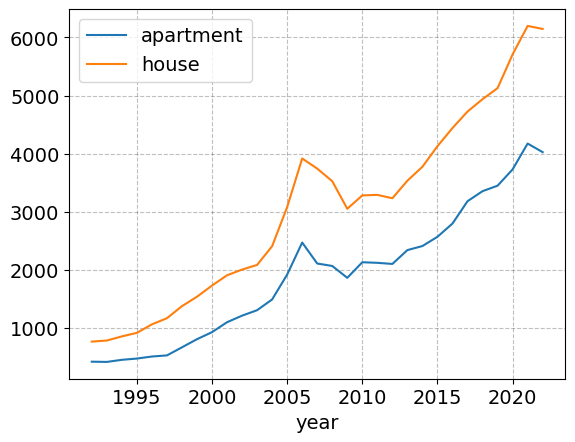

In [37]:
# Data with København Apartments
ap_long_2 = ap_long.reset_index()
ap_long_2.loc[ap_long_2.County == 'Landsdel Byen København', :] 
ap_københavn = ap_long_2.loc[ap_long_2['County'] == 'Landsdel Byen København', :]

# Data with København Houses
house_long_2 = house_long.reset_index()
house_long_2.loc[house_long_2.County == 'Landsdel Byen København', :]
house_københavn = house_long_2.loc[house_long_2['County'] == 'Landsdel Byen København', :]
# Data with Nordjylland
house_long_3 = house_long.reset_index()
house_long_3.loc[house_long_3.County == 'Landsdel Nordjylland', :]
house_nordjylland = house_long_3.loc[house_long_3['County'] == 'Landsdel Nordjylland', :]

# Plotting
ax = ap_københavn.plot(x='year', y='ap', label = 'apartment')
house_københavn.plot(x='year', y='house', ax=ax)



The prices in Copenhagen has increased a lot the last 30 years. One factor that has contributed to the rise in house prices in the recent years, is the low interest rate. This has made it more affordable til take out mortages and purchase homes. 
The increased prices on apartments and house has almost been the same over the past 30 years

Interactive plot showing the development of the prices on houses in the different counties in Denmark.

In [14]:
# defiition of the plot function
def plot_func(df, County):
    # Function that operates on data set
    I = df['County'] == County
    ax=df.loc[I,:].plot(x='year', y='house', style='-o', legend=False)
 # setting the interactive widget
widgets.interact(plot_func, 
    df = widgets.fixed(house_long_2),
    County = widgets.Dropdown(description='County', 
                                    options=house_long_2.County.unique(), 
                                    value='Landsdel Byen København')
);


interactive(children=(Dropdown(description='County', options=('Landsdel Byen København', 'Landsdel Københavns …

The change in houseprices has been more volatile in the big cities in the Denmark compared to the small cities. The financial crisis has made a bigger decrease on the house prices in Copenhagen than in Nordjylland. 

# Merge data sets

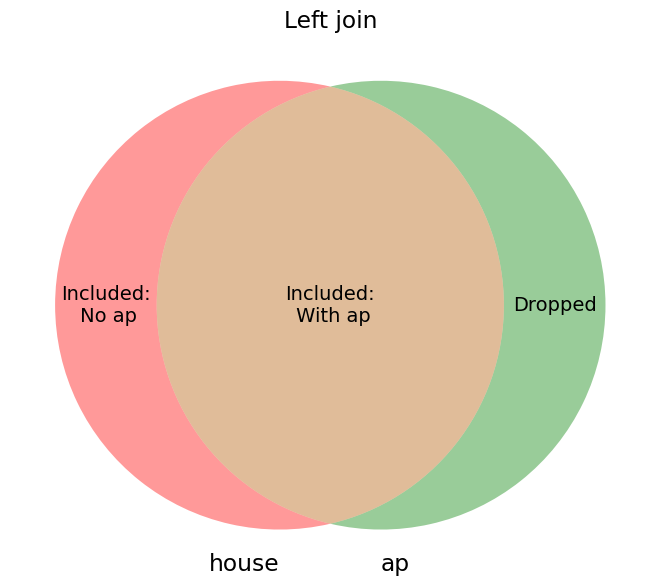

In [59]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('house', 'ap'))
v.get_label_by_id('100').set_text('Included:\n No ap')
v.get_label_by_id('010').set_text('Dropped' )
v.get_label_by_id('110').set_text('Included:\n With ap')
plt.title('Left join')
plt.show()

Merging the data

In [16]:
# We make a left join merge 
join = pd.merge(house, ap, on='County', how='left')
join.head(10)


,County,house1992,house1993,house1994,house1995,house1996,house1997,house1998,house1999,house2000,...,ap2013,ap2014,ap2015,ap2016,ap2017,ap2018,ap2019,ap2020,ap2021,ap2022
0,Landsdel Byen København,767,785,856,917,1063,1169,1376,1539,1731,...,2341,2411,2570,2798,3182,3355,3449,3730,4174,4026
1,Landsdel Københavns omegn,836,844,955,1029,1204,1321,1472,1628,1784,...,1761,1812,1846,1947,2112,2229,2389,2556,2747,2686
2,Landsdel Nordsjælland,797,810,901,965,1126,1226,1373,1536,1674,...,1690,1748,1834,1782,1964,2128,2112,2307,2521,2439
3,Landsdel Bornholm,335,341,368,388,434,453,475,496,531,...,607,679,700,875,898,657,809,895,1274,948
4,Landsdel Østsjælland,704,716,813,879,1013,1106,1240,1338,1467,...,1406,1387,1582,1723,1787,1938,2093,2302,2495,2383
5,Landsdel Vest- og Sydsjælland,445,457,490,517,567,616,675,732,795,...,906,958,999,1058,1076,1087,1133,1179,1268,1259
6,Landsdel Fyn,470,477,523,555,639,686,785,816,860,...,1149,1198,1354,1340,1438,1585,1651,1750,1757,1770
7,Landsdel Sydjylland,494,508,559,583,664,704,754,810,852,...,1089,1083,1191,1177,1231,1366,1450,1407,1546,1506
8,Landsdel Østjylland,557,564,626,662,774,820,910,971,1035,...,1582,1690,1791,1825,1973,2017,2145,2272,2476,2363
9,Landsdel Vestjylland,471,483,530,558,617,646,699,737,767,...,1069,1017,1065,1047,1127,1152,1168,1137,1259,1221


In [17]:
join_long = join.melt(id_vars=['County'], var_name = 'Year', value_name='Price')
join_long['Type'] = join_long['Year'].str[:-4]
join_long['Year'] = join_long['Year'].str[-4:]
join_long['County'] = join_long['County'].str.slice(start=9)
join_long.sort_values(['Year', 'County'], ignore_index=True)

,County,Year,Price,Type
0,Bornholm,1992,335,house
1,Bornholm,1992,377,ap
2,Byen København,1992,767,house
3,Byen København,1992,421,ap
4,Fyn,1992,470,house
...,...,...,...,...
677,Vestjylland,2022,1221,ap
678,Østjylland,2022,2655,house
679,Østjylland,2022,2363,ap
680,Østsjælland,2022,3684,house


# Analysis

In the analysis we are comparing the growth rate and the geometric mean in house and apartment prices in Copenhagen

In [19]:
# We calculate the growthrate and the geometric mean
house_københavn['Growth_Rate'] = (house_københavn['house'].pct_change(periods=1) * 100)
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())
gm1 = g_mean(house_københavn['Growth_Rate'])
print ("%.2f" % gm1)
house_københavn['Gmean'] = gm1
house_københavn['D_Gmean'] = house_københavn.Growth_Rate - house_københavn.Gmean
house_københavn.head(10)

7.72


/var/folders/5k/v848_lfn4c7fkwyhsjyv_0b40000gn/T/ipykernel_87581/998161203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_københavn['Growth_Rate'] = (house_københavn['house'].pct_change(periods=1) * 100)
/Users/sofiesyberg/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/5k/v848_lfn4c7fkwyhsjyv_0b40000gn/T/ipykernel_87581/998161203.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,County,year,house,Growth_Rate,Gmean,D_Gmean
0,Landsdel Byen København,1992,767,NaN,7.718157,NaN
11,Landsdel Byen København,1993,785,2.346806,7.718157,-5.371351
22,Landsdel Byen København,1994,856,9.044586,7.718157,1.326429
33,Landsdel Byen København,1995,917,7.126168,7.718157,-0.591988
44,Landsdel Byen København,1996,1063,15.921483,7.718157,8.203327
55,Landsdel Byen København,1997,1169,9.971778,7.718157,2.253621
66,Landsdel Byen København,1998,1376,17.707442,7.718157,9.989286
77,Landsdel Byen København,1999,1539,11.845930,7.718157,4.127774
88,Landsdel Byen København,2000,1731,12.475634,7.718157,4.757477
99,Landsdel Byen København,2001,1908,10.225303,7.718157,2.507147


In [20]:
# We drop the NaN value from the dataset 
house_københavn2 = house_københavn.dropna()
house_københavn2.head(10)

,County,year,house,Growth_Rate,Gmean,D_Gmean
11,Landsdel Byen København,1993,785,2.346806,7.718157,-5.371351
22,Landsdel Byen København,1994,856,9.044586,7.718157,1.326429
33,Landsdel Byen København,1995,917,7.126168,7.718157,-0.591988
44,Landsdel Byen København,1996,1063,15.921483,7.718157,8.203327
55,Landsdel Byen København,1997,1169,9.971778,7.718157,2.253621
66,Landsdel Byen København,1998,1376,17.707442,7.718157,9.989286
77,Landsdel Byen København,1999,1539,11.845930,7.718157,4.127774
88,Landsdel Byen København,2000,1731,12.475634,7.718157,4.757477
99,Landsdel Byen København,2001,1908,10.225303,7.718157,2.507147
110,Landsdel Byen København,2002,2006,5.136268,7.718157,-2.581888


In [23]:
# We calculate the growrate and the geometric mean in appartment prices in Copenhagen
ap_københavn['Growth_Rate'] = ap_københavn['ap'].pct_change(periods=1) * 100
def g_mean(x):
    a = np.log(x)
    return np.exp(a.mean())
gm2 = g_mean(ap_københavn['Growth_Rate'])
print ("%.2f" % gm2)
ap_københavn['Gmean'] = gm2
ap_københavn['D_Gmean'] = ap_københavn.Growth_Rate - ap_københavn.Gmean
ap_københavn.head(10)

9.97


/var/folders/5k/v848_lfn4c7fkwyhsjyv_0b40000gn/T/ipykernel_87581/2229355650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ap_københavn['Growth_Rate'] = ap_københavn['ap'].pct_change(periods=1) * 100
/Users/sofiesyberg/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/5k/v848_lfn4c7fkwyhsjyv_0b40000gn/T/ipykernel_87581/2229355650.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,County,year,ap,Growth_Rate,Gmean,D_Gmean
0,Landsdel Byen København,1992,421,NaN,9.970975,NaN
11,Landsdel Byen København,1993,417,-0.950119,9.970975,-10.921093
22,Landsdel Byen København,1994,453,8.633094,9.970975,-1.337881
33,Landsdel Byen København,1995,475,4.856512,9.970975,-5.114462
44,Landsdel Byen København,1996,510,7.368421,9.970975,-2.602554
55,Landsdel Byen København,1997,529,3.725490,9.970975,-6.245484
66,Landsdel Byen København,1998,668,26.275992,9.970975,16.305018
77,Landsdel Byen København,1999,808,20.958084,9.970975,10.987109
88,Landsdel Byen København,2000,929,14.975248,9.970975,5.004273
99,Landsdel Byen København,2001,1100,18.406889,9.970975,8.435915


In [24]:
# We drop the NaN value from the dataset 
ap_københavn2 = ap_københavn.dropna()
ap_københavn2['Growth_Rate'].round(2)
ap_københavn2.head(10)

,County,year,ap,Growth_Rate,Gmean,D_Gmean
11,Landsdel Byen København,1993,417,-0.950119,9.970975,-10.921093
22,Landsdel Byen København,1994,453,8.633094,9.970975,-1.337881
33,Landsdel Byen København,1995,475,4.856512,9.970975,-5.114462
44,Landsdel Byen København,1996,510,7.368421,9.970975,-2.602554
55,Landsdel Byen København,1997,529,3.725490,9.970975,-6.245484
66,Landsdel Byen København,1998,668,26.275992,9.970975,16.305018
77,Landsdel Byen København,1999,808,20.958084,9.970975,10.987109
88,Landsdel Byen København,2000,929,14.975248,9.970975,5.004273
99,Landsdel Byen København,2001,1100,18.406889,9.970975,8.435915
110,Landsdel Byen København,2002,1213,10.272727,9.970975,0.301753


Plotting growth rate and the geometric mean of the house and apartments in Copenhagen

<AxesSubplot:xlabel='year'>

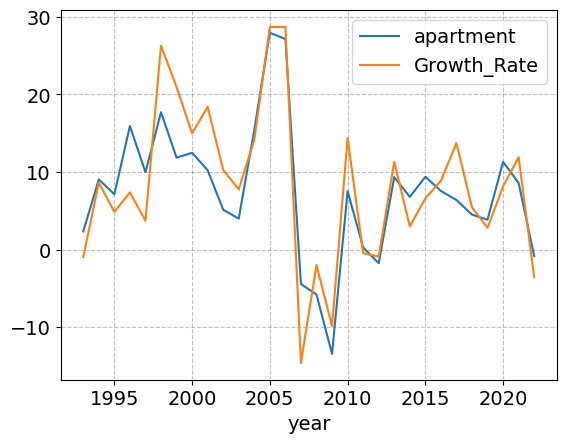

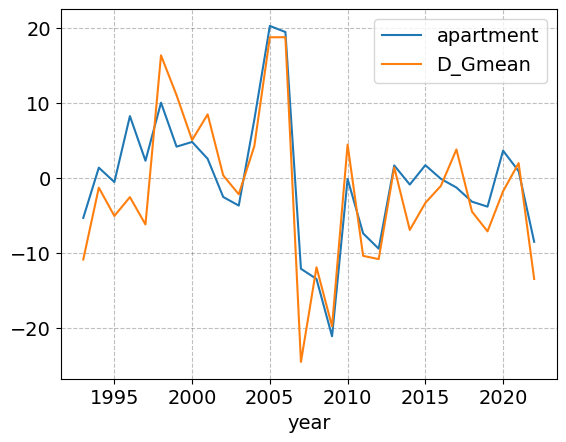

In [33]:
# Plotting growth rate and the geometric mean
ax = house_københavn2.plot(x='year', y='Growth_Rate', label = 'apartment')
ap_københavn2.plot(x='year', y='Growth_Rate', ax=ax)

ax = house_københavn2.plot(x='year', y='D_Gmean', label = 'apartment')
ap_københavn2.plot(x='year', y='D_Gmean', ax=ax)



# Conclusion

In this project we have plotted the house prices, the growth rate and the geometric mean. 
It has been shows that there has been an significant increase in the house prices especially in Copenhagen. It has also been shown that the crisis in 2008 made a fluctuation in the prices, which has the biggest effect in the capital, Copnehagen, 